In [4]:
# Import Aer, transpile and execute
from qiskit import transpile
from qiskit_aer import AerSimulator  # as of 25Mar2025
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT, UnitaryGate, PhaseGate, RZGate
from qiskit.quantum_info import Operator

import sys
sys.path.append('../') # Relative imports in jupyter notebooks are also a mess, but that´s a whole other story
from Hamiltonians_and_Lindbladians.utils_hamiltonian_simulation import *
from qiskit.visualization import plot_histogram, plot_state_city
from sympy import Matrix, latex
from IPython.display import display, Math
import matplotlib.pyplot as plt

## Preface: quantum vs non-quantum Ising models:

If one were to Google "Ising Model", like I was for the past couple hours, there is a high chance one will encounter two different formulations of the Ising model: The "classical" Ising model, which defines a Hamiltonian as

$$ H = -j \sum_{<i,j>} s_i s_j - h \sum_i s_i $$

where $s_i$ are the spins, $j$ is the coupling constant, and $h$ is the external magnetic field. The sum is over nearest neighbors.
The second formulation is the quantum Ising model, which is defined as

$$ H = -j \sum_{<i,j>} \sigma_i^z \sigma_j^z - h \sum_i \sigma_i^x $$

where $\sigma_i^z$ and $\sigma_i^x$ are the Pauli matrices. The sum is over nearest neighbors. 

The quantum Ising model is a quantum mechanical version of the classical Ising model, and it describes the behavior of spins in a magnetic field. The classical Ising model is a statistical mechanics model that describes the behavior of spins in a lattice, and it is used to study phase transitions and critical phenomena.

The quantum Ising model is a generalization of the classical Ising model, and it includes quantum effects such as tunneling and entanglement. The quantum Ising model can be solved using various methods, including mean-field theory, renormalization group theory, and numerical simulations.

(Obviously) I will focus on the quantum Ising model in this notebook, as it maps amazingly naturally to the quantum circuit model of computation. 


On a more superficial note, a  nicer notation (in my optinion at least) is to write the Hamiltonian as
$$
H_\mathrm{Ising} = - J \sum_{j=1}^{N-1} Z^{(j)} Z^{(j+1)} + g\sum_{j=1}^N X^{(j)}
$$

such that $\forall j \in \{1, \ldots, N\} $ we have $Z^{(j)}$ and $X^{(j)}$ are the Pauli matrices acting on the $j$-th qubit - aka we actually have an n-fold tensor product $H_j = \bigotimes_{j=0}^N \sigma_j\,, \quad \sigma_j \in \{I, X, Y, Z\}$ where every entry is just the identity matrix except for the $j$-th entry which is the specified Pauli matrix.

Check this souce out: https://people.maths.bris.ac.uk/~csxam/teaching/qc2020/lecturenotes.pdf


In [33]:
def generate_ising_hamiltonian(num_qubits: int, J, g) -> Union[SparsePauliOp, Pauli]:
    z_terms = []
    z_coeffs = []
    
    # ZZ interaction terms
    for j in range(num_qubits):
        pauli_string = ['I'] * num_qubits
        pauli_string[j] = 'Z'
        pauli_string[(j + 1) % num_qubits] = 'Z'  # Periodic boundary conditions
        z_terms.append("".join(pauli_string))
        z_coeffs.append(-J)  # Coefficient for ZZ interaction

    x_terms = []
    x_coeffs = []
    
    # X field terms
    for j in range(num_qubits):
        pauli_string = ['I'] * num_qubits
        pauli_string[j] = 'X'
        x_terms.append("".join(pauli_string))
        x_coeffs.append(-g)  # Coefficient for X term

    # Combine the Z and X terms into a single Hamiltonian
    all_terms = z_terms + x_terms
    all_coeffs = z_coeffs + x_coeffs

    return SparsePauliOp(all_terms, coeffs=all_coeffs)

def exponentiate_hamiltonian(hamiltonian: SparsePauliOp, time: float) -> Operator:
    """Exponentiates the Hamiltonian to obtain U = e^(-i H t)."""
    matrix = hamiltonian.to_matrix()
    unitary_matrix = scipy.linalg.expm(-1j * time * matrix)
    display(Math(latex(Matrix(unitary_matrix))))  # Display the unitary matrix in LaTeX format
    return Operator(unitary_matrix)

# example for 2 qubits
H = generate_ising_hamiltonian(2, 1.2, 1)
H

SparsePauliOp(['ZZ', 'ZZ', 'XI', 'IX'],
              coeffs=[-1.2+0.j, -1.2+0.j, -1. +0.j, -1. +0.j])

### (a) $g = 0$ (Classical Ising Limit)

The Hamiltonian reduces to a classical Ising model with only $Z_j Z_{j+1}$ interactions.

The ground states are ferromagnetic states:

$|00\ldots 0\rangle$ and $|11\ldots 1\rangle$  
(or in the Pauli-$X$ basis, $|\uparrow\uparrow\cdots\uparrow\rangle$ and $|\downarrow\downarrow\cdots\downarrow\rangle$).

The energy eigenvalues are:

$E = -JN,\ -J(N-4),\ \ldots,\ JN$

with different spin flip excitations.

### (b) $J = 0$ (Quantum Paramagnetic Limit)

The Hamiltonian reduces to a transverse field only:

$H = -g \sum_j X_j$

The ground state is a fully polarized state in the $X$-basis:

$|+\rangle^{\otimes N} = \frac{1}{\sqrt{2^N}} \sum_z |z\rangle$

Eigenvalues are:

$E = -gN,\ -g(N-2),\ \ldots,\ gN$


In [3]:
H = generate_ising_hamiltonian(2, 1.2, 1)

# Convert to matrix form
H_matrix = H.to_matrix()

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(H_matrix)

# Display eigenvalues and eigenvectors
latex_vecs = latex(Matrix(eigenvectors))  # Convert matrix to LaTeX format
display(Math(r"\text{Eigenvectors: } " + latex_vecs))
print("Eigenvalues: ", eigenvalues)

<IPython.core.display.Math object>

Eigenvalues:  [-3.12409987 -2.4         2.4         3.12409987]


## **Effect of MSB Choice in Quantum Phase Estimation (QPE)**

### **1. Overview**
Quantum Phase Estimation (QPE) extracts the phase $\theta $ in the eigenvalue equation:

$$
U | \psi \rangle = e^{2\pi i \theta} | \psi \rangle
$$

where $ U $ is a unitary matrix with eigenvalue $ e^{2\pi i \theta} $. The algorithm encodes $ \theta $ using a register of $ t $ ancilla qubits and controlled-$ U^{2^k} $ operations.

---

### **2. Controlled-$ U^{2^k} $ Order**
The choice of whether the **most significant bit (MSB) or least significant bit (LSB) is assigned to qubit 0** determines how powers of $ U $ are applied.

- **MSB-first (Standard Convention)**
  - Qubit $ 0 $ controls $ U^{2^0} $.
  - Qubit $ 1 $ controls $ U^{2^1} $.
  - Qubit $ t-1 $ controls $ U^{2^{t-1}} $.
  - The measurement outcome is in **standard binary order**, directly yielding:

    $$
    \theta \approx \frac{j}{2^t}
    $$

    where $j $ is the measurement outcome in binary.

- **LSB-first (Alternative Convention)**
  - Qubit $ 0 $ controls $ U^{2^{t-1}} $.
  - Qubit $ 1 $ controls $ U^{2^{t-2}} $.
  - Qubit $ t-1 $ controls $ U^{2^0} $.
  - The measurement outcome is in **bit-reversed order**, yielding:

    $$
    \theta \approx \frac{j_{\mathrm{rev}}}{2^t}
    $$

    where $ j_{\mathrm{rev}} $ is the bit-reversed measurement outcome.
    - This requires additional processing to recover the original phase estimate.

## **5. Conclusion**
- The **MSB-first convention** directly encodes \( \theta \) in standard binary fraction form.
- The **LSB-first convention** leads to a **bit-reversed result**, requiring additional processing to recover \( \theta \).


In [2]:


def test_many_implementations_of_qpe(U, num_qubits, num_ancilla, eigenstate):
    qpe_circ_1 = standard_qpe(unitary=U, eigenstate=eigenstate, num_ancilla=num_ancilla, swap=True)
    qpe_circ_2 = standard_qpe(unitary=U, eigenstate=eigenstate, num_ancilla=num_ancilla, swap=False)
    qpe_circ_3 = standard_qpe_v2(unitary=U, eigenstate=eigenstate, num_ancilla=num_ancilla, num_target=num_qubits, swap=True)
    qpe_circ_4 = standard_qpe_v2(unitary=U, eigenstate=eigenstate, num_ancilla=num_ancilla, num_target=num_qubits, swap=False)

    return [qpe_circ_1, qpe_circ_2, qpe_circ_3, qpe_circ_4]

    

In [6]:
# Negative control: run QPE on I
I = Operator.from_label('I'*2)
times = [10, 1, 0.1, 0.01, 0.001]
num_ancilla = 3
for t in times:
    eigenvect = Statevector.from_label('00')
    circuits = test_many_implementations_of_qpe(U=I, num_qubits=2, num_ancilla=num_ancilla, eigenstate=eigenvect)
    simulator = AerSimulator()
    all_counts = []
    for circ in circuits:
        transpiled_circ = transpile(circ, simulator)
        result = simulator.run(transpiled_circ).result()
        counts = result.get_counts()
        all_counts.append(counts)
    # Plot histograms for each circuit
    fig, axs = plt.subplots(1, len(circuits), figsize=(15, 5))
    for i, counts in enumerate(all_counts):
        axs[i].bar(counts.keys(), counts.values())
        axs[i].set_title(f"Circuit {i+1}")
        axs[i].set_xlabel("Measurement")
        axs[i].set_ylabel("Counts")
    plt.suptitle(f"QPE on I with t={t}")
    plt.tight_layout()
    plt.show()

    # calculate real eigenvalue, corresponding to the chosen eigenstate
    # look for the eigenvalue corresponding to the chosen eigenstate
    eigenstate = Statevector.from_label('00')
    eigenvalue = np.dot(eigenstate, np.dot(I.to_matrix(), eigenstate))
    print(f"Eigenvalue for eigenstate {eigenstate}: {eigenvalue}")

    most_freq_bitstring = max(counts, key=counts.get)
    estimated_eigenvalue = np.exp(1j * int(most_freq_bitstring, 2) / (2**num_ancilla) )
    print(f"Estimated eigenvalue from QPE: {estimated_eigenvalue}")

    

AttributeError: 'Operator' object has no attribute 'control'

<IPython.core.display.Math object>

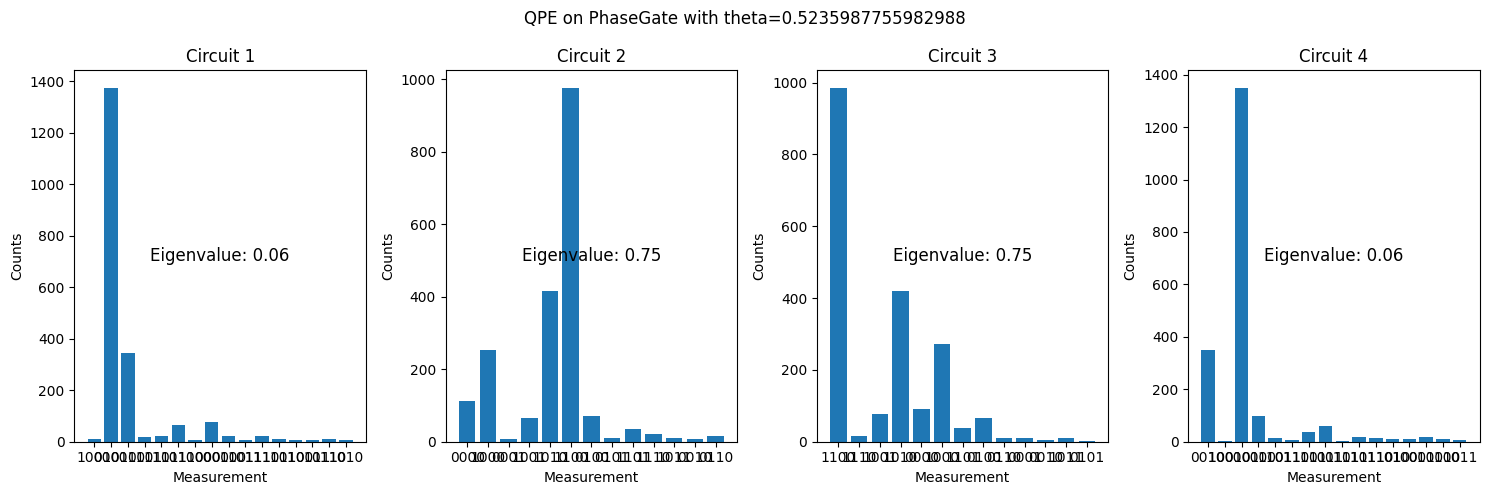

<IPython.core.display.Math object>

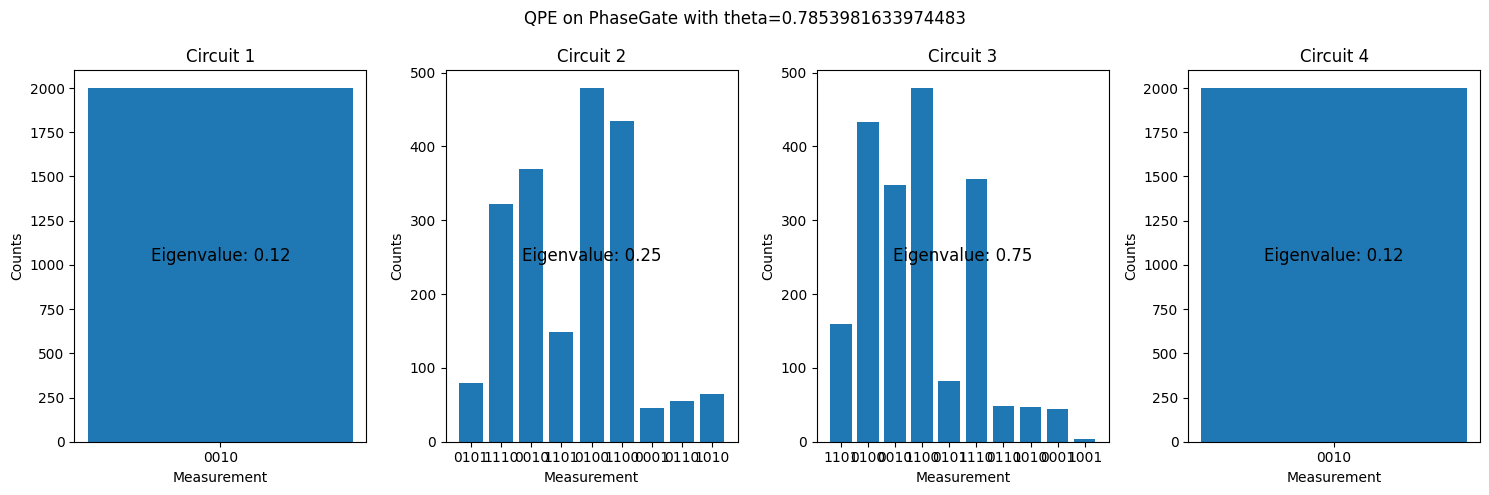

<IPython.core.display.Math object>

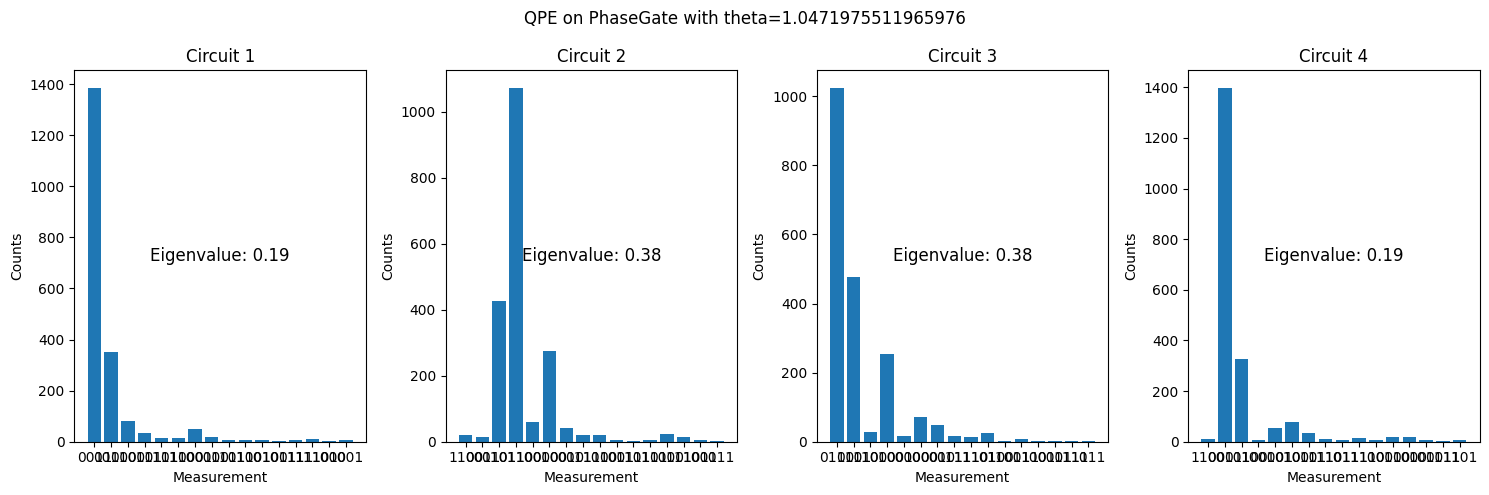

<IPython.core.display.Math object>

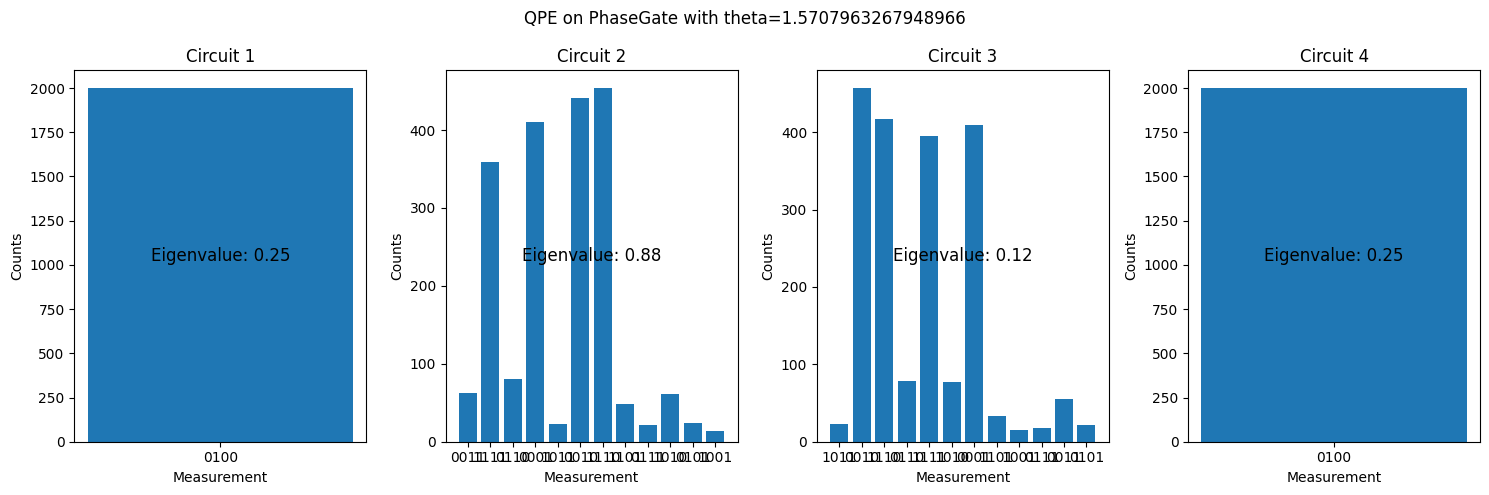

In [10]:
angles =[np.pi/6, np.pi/4, np.pi/3, np.pi/2,]
for theta in angles:
    phase_gate = PhaseGate(theta)
    eigenvalue = Statevector.from_label('1')
    U = phase_gate
    display(Math(latex(Matrix(U.to_matrix()))))  # Display the unitary matrix in LaTeX format

    eigevector = Statevector.from_label('1')
    circuits = test_many_implementations_of_qpe(U=U, num_qubits=1, num_ancilla=4, eigenstate=eigevector)
    simulator = AerSimulator()
    all_counts = []

    for circ in circuits:
        transpiled_circ = transpile(circ, simulator)
        result = simulator.run(transpiled_circ, shots=2000).result()
        counts = result.get_counts()
        all_counts.append(counts)
    # Plot histograms for each circuit
    fig, axs = plt.subplots(1, len(circuits), figsize=(15, 5))
    for i, counts in enumerate(all_counts):
        axs[i].bar(counts.keys(), counts.values())
        axs[i].set_title(f"Circuit {i+1}")
        axs[i].set_xlabel("Measurement")
        axs[i].set_ylabel("Counts")
        phase = int(counts.most_frequent(), 2) / (2**4)
        axs[i].text(0.5, 0.5, f"Eigenvalue: {phase:.2f}", fontsize=12, ha='center', va='center', transform=axs[i].transAxes)
    plt.suptitle(f"QPE on PhaseGate with theta={theta}")
    plt.tight_layout()
    plt.show()

<IPython.core.display.Math object>

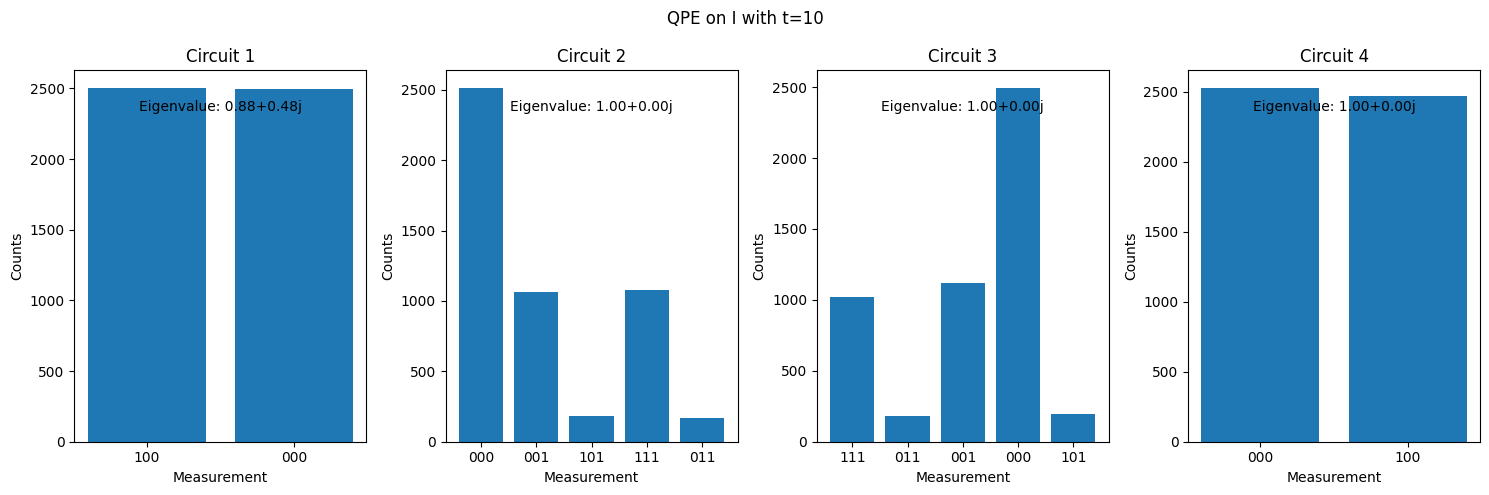

Eigenvalues:  [-1. -1.  1.  1.]


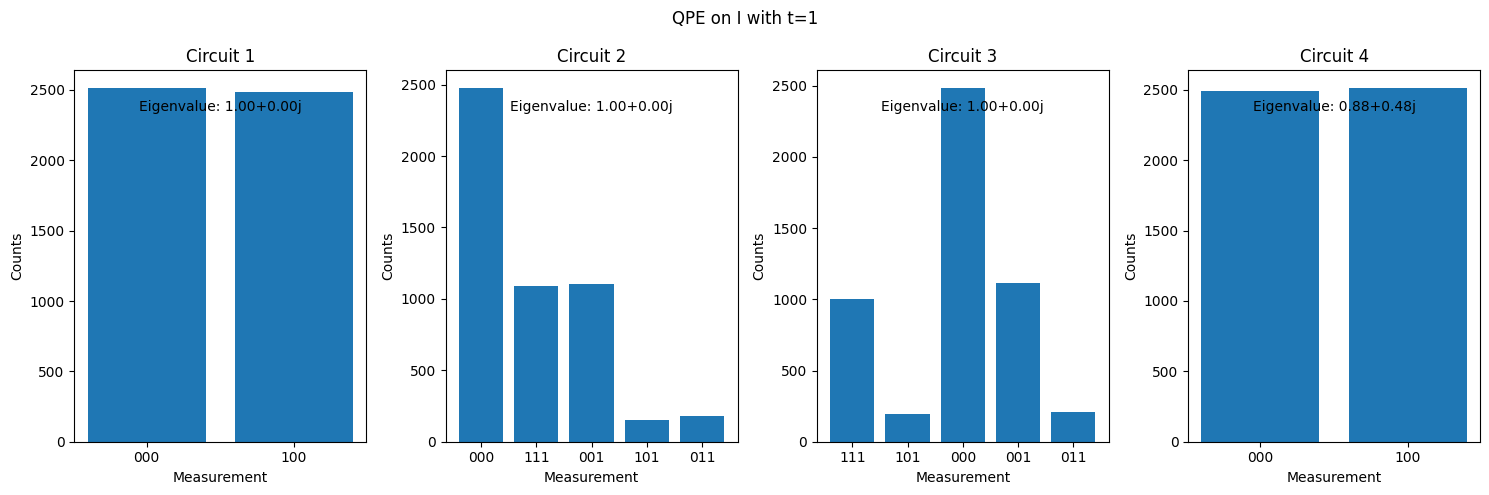

Eigenvalues:  [-1. -1.  1.  1.]


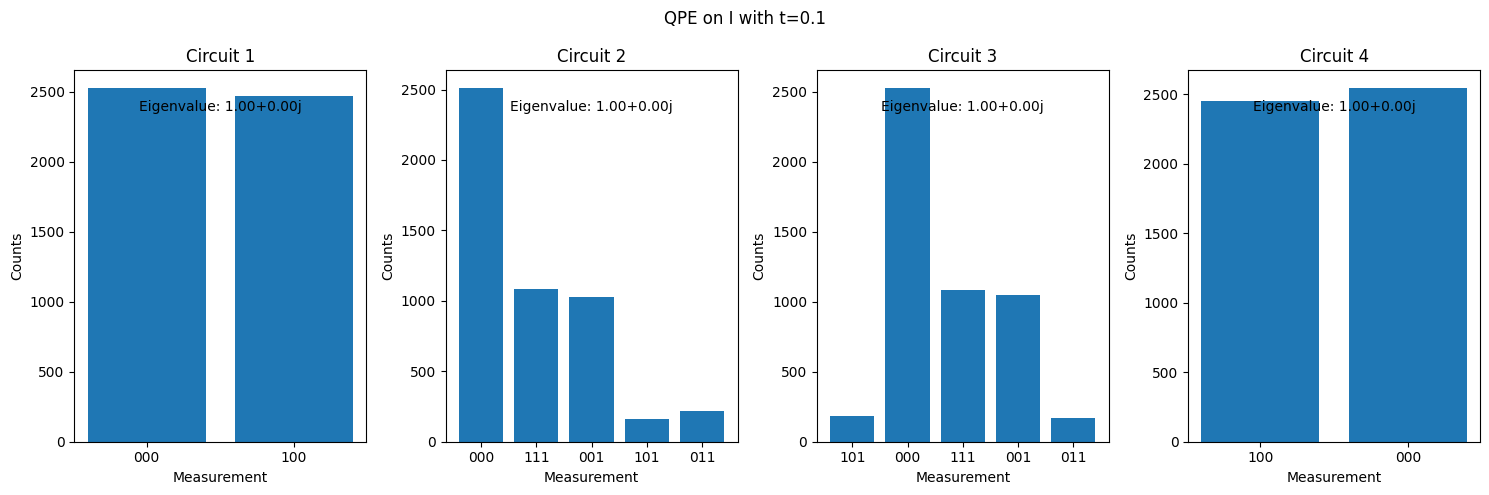

Eigenvalues:  [-1. -1.  1.  1.]


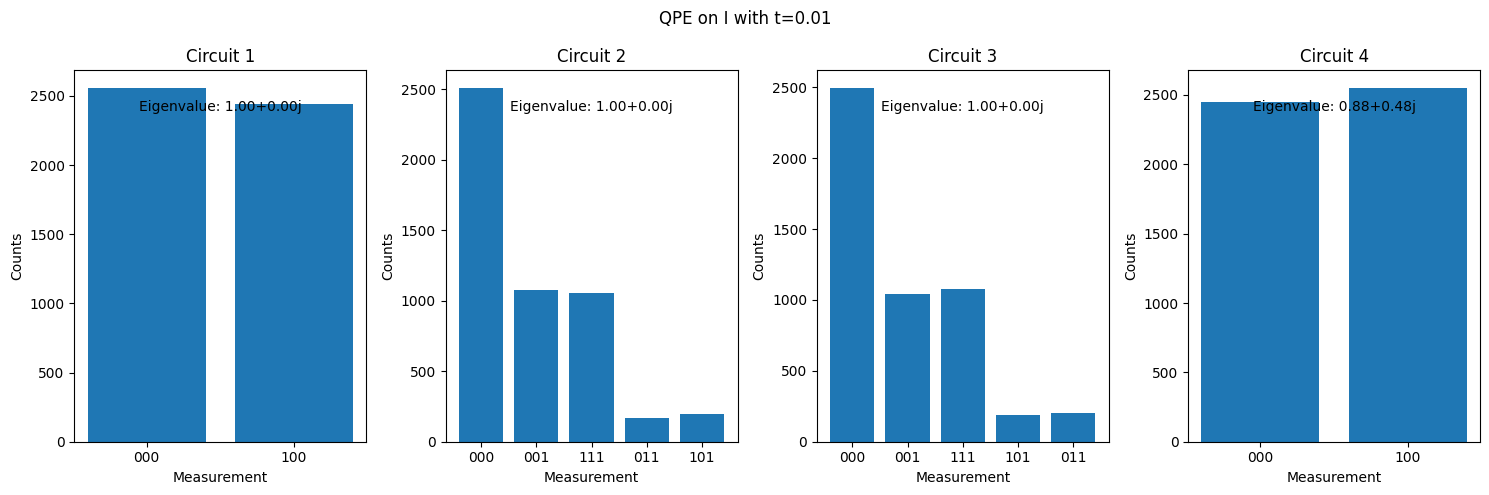

Eigenvalues:  [-1. -1.  1.  1.]


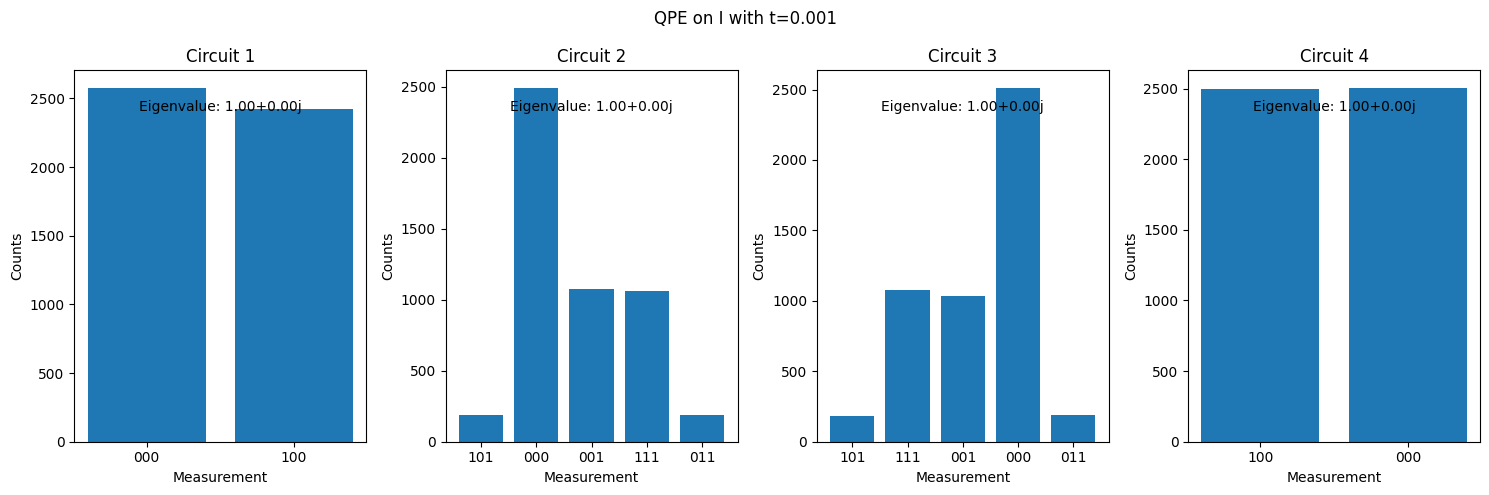

Eigenvalues:  [-1. -1.  1.  1.]


In [37]:
times = [10, 1, 0.1, 0.01, 0.001]
num_ancilla = 3
U = Operator.from_label('XH')
display(Math(r"\text{Unitary: } " + latex(Matrix(U.to_matrix()))))
for t in times:
    eigenvect = Statevector.from_label('00')
    circuits = test_many_implementations_of_qpe(U=U, num_qubits=2, num_ancilla=num_ancilla, eigenstate=eigenvect)
    simulator = AerSimulator()
    all_counts = []
    for circ in circuits:
        transpiled_circ = transpile(circ, simulator)
        result = simulator.run(transpiled_circ, shots=5000).result()
        counts = result.get_counts()
        all_counts.append(counts)
    # Plot histograms for each circuit
    fig, axs = plt.subplots(1, len(circuits), figsize=(15, 5))
    for i, counts in enumerate(all_counts):
        most_freq_bitstring = max(counts, key=counts.get)
        estimated_eigenvalue = np.exp(1j * int(most_freq_bitstring, 2) / (2**num_ancilla) )
        axs[i].bar(counts.keys(), counts.values())
        axs[i].set_title(f"Circuit {i+1}")
        axs[i].set_xlabel("Measurement")
        axs[i].set_ylabel("Counts")

        # add estimated eigenvalue to the plot
        axs[i].text(0.5, 0.9, f"Eigenvalue: {estimated_eigenvalue:.2f}", ha='center', va='center', transform=axs[i].transAxes)
    plt.suptitle(f"QPE on I with t={t}")
    plt.tight_layout()
    plt.show()

    # calculate real eigenvalue, corresponding to the chosen eigenstate
    # look for the eigenvalue corresponding to the chosen eigenstate
    eigenvalues, eigenstates = np.linalg.eigh(U.to_matrix())
    print("Eigenvalues: ", eigenvalues)

    



<IPython.core.display.Math object>

<IPython.core.display.Math object>

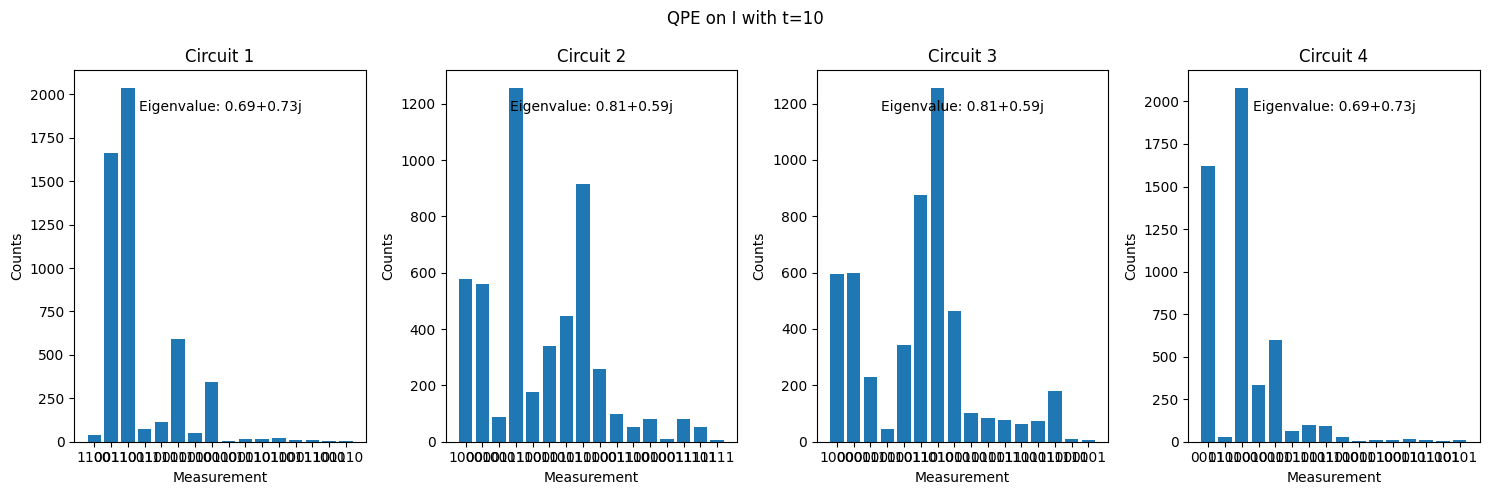

Eigenvalues:  [0.17800058 0.26826224 1.14065587 1.23091752]


<IPython.core.display.Math object>

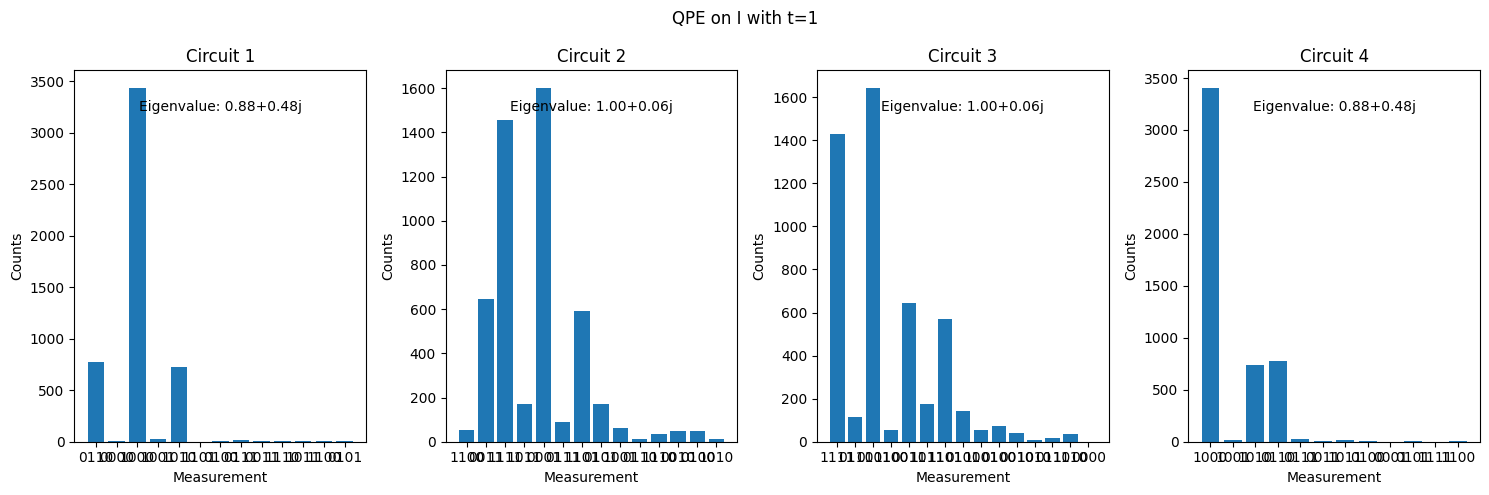

Eigenvalues:  [-1.22995097 -1.21954109 -0.51769963 -0.50728975]


<IPython.core.display.Math object>

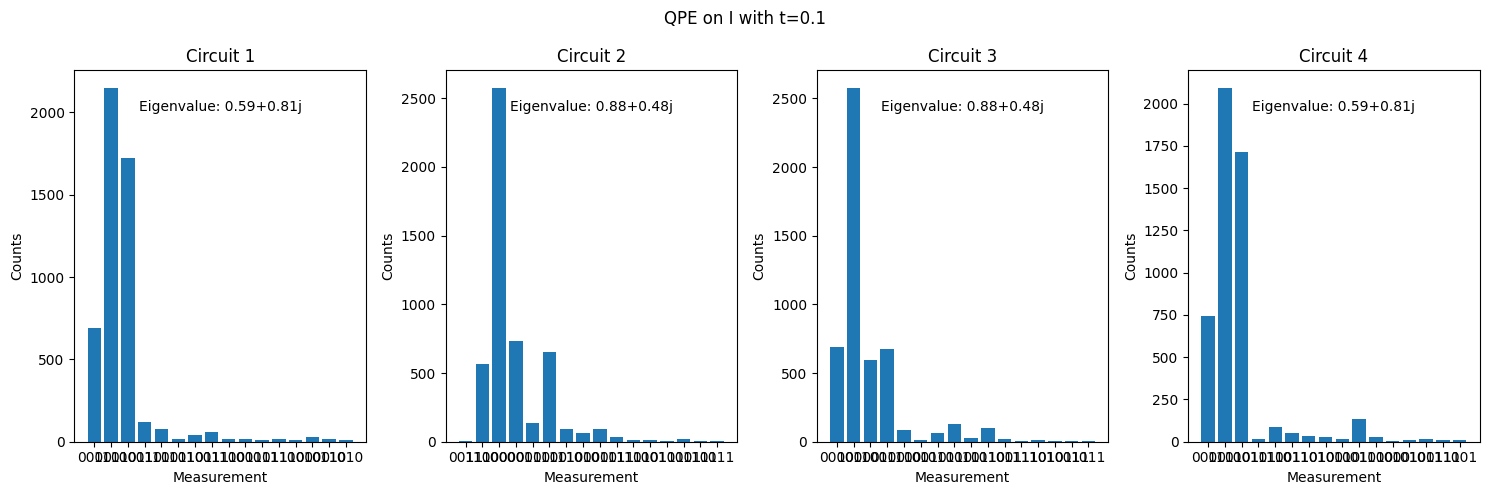

Eigenvalues:  [0.76445364 0.95159562 0.97133798 1.15847995]


<IPython.core.display.Math object>

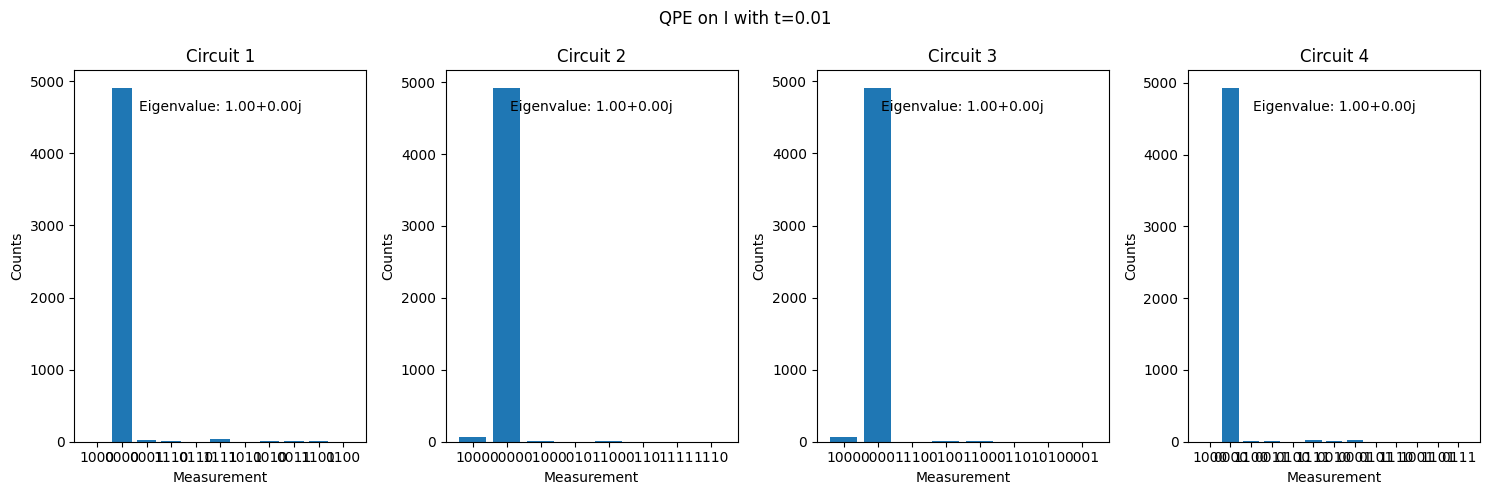

Eigenvalues:  [0.97961503 0.99951204 0.99971201 1.01960902]


<IPython.core.display.Math object>

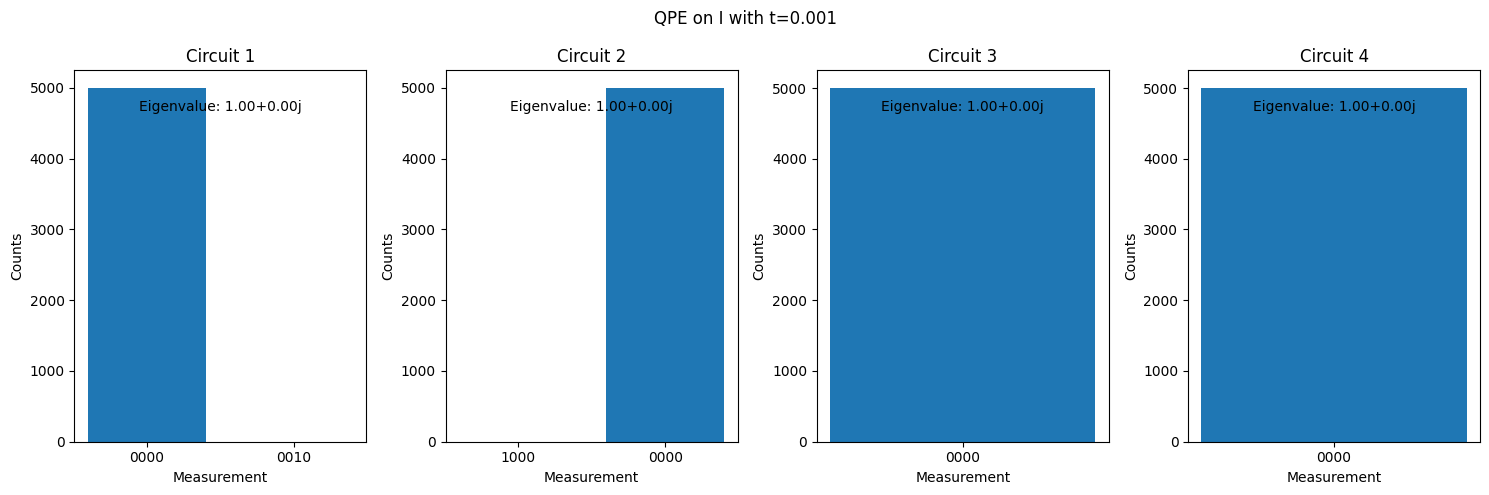

Eigenvalues:  [0.99799612 0.99999512 0.99999712 1.00199612]


In [39]:
times = [10, 1, 0.1, 0.01, 0.001]
num_ancilla = 4
H = generate_ising_hamiltonian(2, 1.2, 1)
display(Math(r"\text{Unitary: } " + latex(Matrix(H.to_matrix()))))
for t in times:
    U = exponentiate_hamiltonian(H, t)
    eigenvalues, eigenstates = np.linalg.eigh(U.to_matrix())
    first_column = eigenstates[:, 0]
    eigenvect = Statevector(first_column)
    
    circuits = test_many_implementations_of_qpe(U=U, num_qubits=2, num_ancilla=num_ancilla, eigenstate=eigenvect)
    simulator = AerSimulator()
    all_counts = []
    for circ in circuits:
        transpiled_circ = transpile(circ, simulator)
        result = simulator.run(transpiled_circ, shots=5000).result()
        counts = result.get_counts()
        all_counts.append(counts)
    # Plot histograms for each circuit
    fig, axs = plt.subplots(1, len(circuits), figsize=(15, 5))
    for i, counts in enumerate(all_counts):
        most_freq_bitstring = max(counts, key=counts.get)
        estimated_eigenvalue = np.exp(1j * int(most_freq_bitstring, 2) / (2**num_ancilla) )
        axs[i].bar(counts.keys(), counts.values())
        axs[i].set_title(f"Circuit {i+1}")
        axs[i].set_xlabel("Measurement")
        axs[i].set_ylabel("Counts")

        # add estimated eigenvalue to the plot
        axs[i].text(0.5, 0.9, f"Eigenvalue: {estimated_eigenvalue:.2f}", ha='center', va='center', transform=axs[i].transAxes)
    plt.suptitle(f"QPE on I with t={t}")
    plt.tight_layout()
    plt.show()

    
    print("Eigenvalues: ", eigenvalues)

In [6]:
t = 1  # Time parameter for the exponentiation
# let´s start simple: a single qubit phase gate
# Phase to estimate
theta = np.pi / 7  

# Unitary operator: Phase Gate
U = PhaseGate(theta)

# Test QPE with the new unitary and |1⟩ as eigenstate
num_ancilla = 3
num_target = 1
display(Math(r"\text{Unitary: } U = e^{-iHt} = " + latex(Matrix(U))))

<IPython.core.display.Math object>

Statevector([0.+0.j, 1.+0.j],
            dims=(2,))


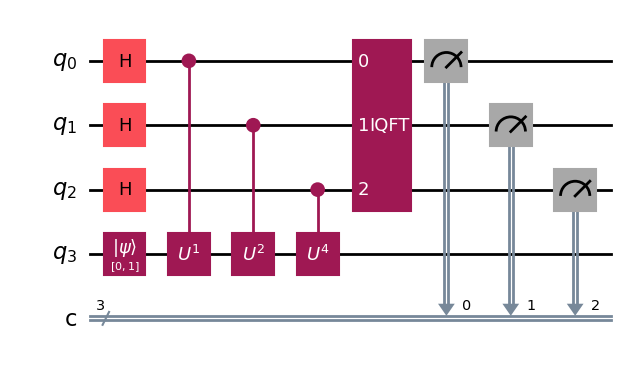

In [7]:

eigenstate = Statevector.from_label('1')  # |1⟩ as the eigenstate
print(eigenstate)
# Create the QPE circuit
qc = standard_qpe(U, eigenstate, num_ancilla=3)
qc.draw('mpl')

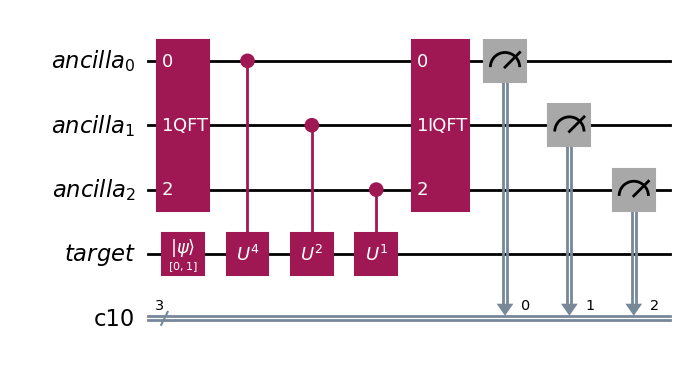

In [8]:
qc2 = standard_qpe_v2(U, eigenstate, num_ancilla=3, num_target=1)
qc2.draw('mpl')

Counts: {'111': 43, '000': 300, '001': 556, '010': 49, '101': 16, '110': 26, '100': 14, '011': 20}


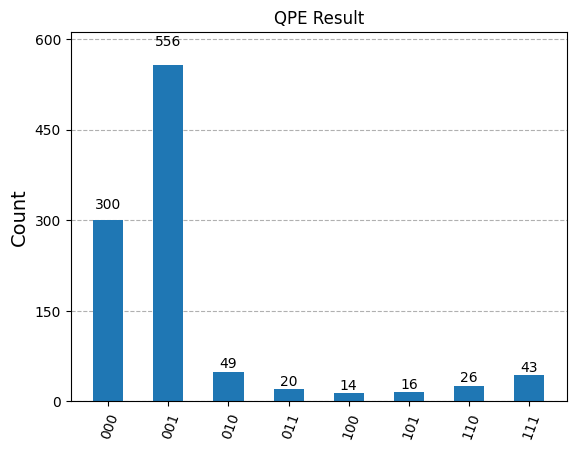

In [9]:
simulator = AerSimulator()
qc_transpiled = transpile(qc, simulator)
# Execute the circuit on the simulator
job = simulator.run(qc_transpiled, shots=1024)
result = job.result()
counts = result.get_counts(qc_transpiled)
# Print the counts
print("Counts:", counts)
# Plot the results
plot_histogram(counts, title="QPE Result")

Counts: {'000': 285, '100': 493, '010': 185, '001': 34, '101': 15, '011': 8, '110': 3, '111': 1}


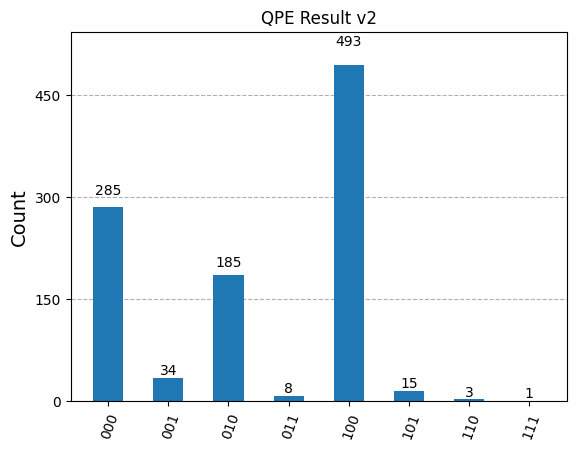

In [10]:
qc2_transpiled = transpile(qc2, simulator)
# Execute the circuit on the simulator
job2 = simulator.run(qc2_transpiled, shots=1024)
result2 = job2.result()
# Get the counts from the result
counts2 = result2.get_counts(qc2_transpiled)
# Print the counts
print("Counts:", counts2)
# Plot the results 
plot_histogram(counts2, title="QPE Result v2")

In [11]:
estimated_phase_1 = int(counts.most_frequent(), 2) / (2**num_ancilla) / t
estimated_phase_2 = int(counts2.most_frequent(), 2) / (2**num_ancilla) / t
print("Estimated phase from standard QPE: ", estimated_phase_1)
print("Estimated phase from standard QPE v2: ", estimated_phase_2)
# Compare with the actual phase
print("Actual phase: ", theta / t)

Estimated phase from standard QPE:  0.125
Estimated phase from standard QPE v2:  0.5
Actual phase:  0.4487989505128276
